# [Hw02] Classification of the Iris data using various classifiers
Jeong Ji Hoon 2016010980

### Import packages

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

### Constants

In [99]:
NUM_FEATURE = 4 # Number of Features in each sample

## 1. Load the Iris dataset using Pandas

In [100]:
#Dataset Download
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',header=None)
dataset = df.values

#Iris name to integer codes
iris_names = np.unique(dataset[:,NUM_FEATURE])
for i,name in enumerate(iris_names):
    dataset[np.where(dataset[:,NUM_FEATURE] == name),NUM_FEATURE] = i

X = dataset[:,:NUM_FEATURE].astype(float)
# Using Only Two Features (Sepal length & Petal Length)
X = X[:,[0,2]]
y = dataset[:,NUM_FEATURE].astype(int)

print('[System] Data import success')

[System] Data import success


### [function] plot_decision_regions
원래 책에 있는 코드에서 아래 사항들을 수정함.
- ax 값을 받아서 원하는 지점의 axis 에 그래프를 그릴 수 있음.
- 기존에는 무조건 min, max feature 값에서 각각 -1, +1을 한 값을 사용했는데, graph_margin을 따로 받도록 함.
    - feature scaling 된 feature 값들에게는 이 -1, +1 값이 너무 커서 그럼.

In [101]:
def plot_decision_regions(X, y, classifier, ax, graph_margin = 1, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - graph_margin, X[:, 0].max() + graph_margin
    x2_min, x2_max = X[:, 1].min() - graph_margin, X[:, 1].max() + graph_margin
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Petal Length')
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')
    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]
        ax.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100,
                    label='test set')

## 2. Perform the feature scaling
- Normalization
- Standardization

In [102]:
## Training Set / Testing Set 분리.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

## Normalization vs Standardization
# Normalization
clf_norm = Normalizer()
clf_norm.fit(X_train)
X_train_norm = clf_norm.transform(X_train)
X_test_norm = clf_norm.transform(X_test)

# Standardization
clf_std = StandardScaler()
clf_std.fit(X_train)
X_train_std = clf_std.transform(X_train)
X_test_std = clf_std.transform(X_test)

## 3. Implement the logistic regression algorithm

### [class] LogisticRegressionGD
원래 책에 있는 코드에서 아래 사항들을 수정함.
- batch_size 값을 받아서 해당 batch size로 mini-batch gradient Descent를 돌릴 수 있음.
- 따로 값을 입력을 안한 경우 batch_size = -1이 대입되며, 이 경우 한번에 weight update를 하는 Batch Gradient Descent를 진행.

In [103]:
class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value in each epoch.

    """

    def __init__(self, eta=0.05, n_iter=100, random_state=1, batch_size=-1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.batch_size = batch_size

    def fit(self, X, y):
        """ Fit training data.
        batch size를 기준으로 입력된 X 값을 batch size로 나눠서 학습을 시킴.
        X 사이즈가 batch size로 딱 나누어 떨어지지 않는 경우,
         맨 마지막 남는 데이터는 batch size 보다 크기가 작아도 그대로 학습을 진행.
         ex) X.shape[0] = 150, batch_size = 100
         epoch1-1 : X[0:100]
         epoch1-2 : X[100:150]
         epoch2-1 : X[0:100]
         epoch2-2 : X[100:150]
       대신 batch size로 -1을 넣는 경우 그냥 batch Gradient Descent 방식을 사용.
        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []
        if self.batch_size == -1: # Batch Gradient
            self.batch_size = X.shape[0]
        for i in range(self.n_iter):
            if X.shape[0] % self.batch_size == 0:  # training set 크기가 batch_size로 딱 나눠지는 경우
                batch_n_iter = int(X.shape[0] / self.batch_size)  # batch를 돌려아 하는 횟수.
                # 딱 나눠지는 경우에는 배치 사이즈 그대로 train을 시킴.
                for b in range(batch_n_iter):
                    smallX = X[self.batch_size * b : self.batch_size * (b + 1), :]
                    smally = y[self.batch_size * b : self.batch_size * (b + 1)]
                    net_input = self.net_input(smallX)
                    output = self.activation(net_input)
                    errors = (smally - output)
                    self.w_[1:] += self.eta * smallX.T.dot(errors)
                    self.w_[0] += self.eta * errors.sum()
                    cost = -smally.dot(np.log(output)) - ((1 - smally).dot(np.log(1 - output)))
                    self.cost_.append(cost)

            else:  # training set 크기가 batchsize로 딱 나눠지지 않는 경우
                batch_n_iter = int(np.floor(X.shape[0] / self.batch_size))
                # 배치 사이즈 그대로 train을 시키고,
                for b in range(batch_n_iter):
                    smallX = X[self.batch_size * b : self.batch_size * (b + 1), :]
                    smally = y[self.batch_size * b : self.batch_size * (b + 1)]
                    net_input = self.net_input(smallX)
                    output = self.activation(net_input)
                    errors = (smally - output)
                    self.w_[1:] += self.eta * smallX.T.dot(errors)
                    self.w_[0] += self.eta * errors.sum()
                    cost = -smally.dot(np.log(output)) - ((1 - smally).dot(np.log(1 - output)))
                    self.cost_.append(cost)
                # 나머지를 전부 넣어줌.
                smallX = X[self.batch_size * batch_n_iter :, :]
                smally = y[self.batch_size * batch_n_iter :]
                net_input = self.net_input(smallX)
                output = self.activation(net_input)
                errors = (smally - output)
                self.w_[1:] += self.eta * smallX.T.dot(errors)
                self.w_[0] += self.eta * errors.sum()
                cost = -smally.dot(np.log(output)) - ((1 - smally).dot(np.log(1 - output)))
                self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # equivalent to:
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

### [class] LogisticRegressionGD_3C
Class 3개 짜리 Classifier.
앞서 정의한 LogisticRegressionGD 세 개를 만들어서 One vs All 방식으로 분류.

In [104]:
class LogisticRegressionGD_3C(object):
    """Class 3개인 데이터를 위한 classifier.
    3개의 LogisticRegressionGD Class를 만든뒤 One Versus All 방식으로 Class를 분류."""
    def __init__(self, eta=0.001, n_iter=1000, random_state=1, batch_size = -1):
        self.clf = [LogisticRegressionGD(eta=eta, n_iter=n_iter, random_state=random_state, batch_size = batch_size),
                    LogisticRegressionGD(eta=eta, n_iter=n_iter, random_state=random_state, batch_size = batch_size),
                    LogisticRegressionGD(eta=eta, n_iter=n_iter, random_state=random_state, batch_size = batch_size)]

    def fit(self, X, y):
        # y값이 -1과 1이 아니라 0,1,2 의 세 숫자로 구성되기에 각 classifier에 맞는 형태로 변형시켜주어야 함.
        y_3C = 0 * np.ones([y.size, 3]) # sample 수 X 3 크기로 전부 0인 array를 만들고,
        for s, c in enumerate(y): # 모든 sample에 대해서
            y_3C[s, c] = 1  # index y에 해당하는 값만 1로 바꿔줌.
            # 이렇게 하면 Class0인 경우 [1,-1,-1], Class1인 경우 [-1,1,-1] 형태의 array가 만들어짐.

        for c in range(3):
            self.clf[c].fit(X,y_3C[:,c])
        return self

    def predict(self, X):
        result = np.zeros([X.shape[0],3])
        for c in range(3):
            result[:,c] = self.clf[c].net_input(X) # predict를 바로 하는 것이 아니라 net_input 값만 받아둠.
        return np.argmax(result, axis=1)

### Parameter Selection
- HW01의 경우 Adaline으로 한번 fit 한뒤 적절한 batchsize와 eta 값을 선정함.
- HW02의 경우 Adaline과는 다른 logistic regression을 사용.
- 또한 Parameter Selection을 할때 서로 다른 train / test set의 조합과 초기 weight 값을 사용해 여러번 Performance를 본뒤 parameter를 결정해주어야 함.
- 이에 아래의 코드는 HW01에 제시된 eta 값, batch size 값을 사용해서 logistic regression을 사용해 각각 10번씩 다른 train / test set과 초기 weight 값 조합으로 performance를 측정함.
- 돌리는데 시간이 오래걸리니 일단 주석처리를 해두고 미리 해둔 결과 그래프를 보여주도록 했음.
- 결론적으로 eta = 0.01, batch size = 4 일 때 30개의 test set에 대해 93.3333%의 정확도를 보였으므로 이 값을 사용하기로 함.

In [105]:

# eta_set = [0.1, 0.01, 0.001, 0.0001]
# batch_set = [1,2,4,8,16,32,120]

# output = pd.DataFrame(np.zeros([4,7]))

# fig1, ax = plt.subplots(4,7)
# for it in range(10):
#     print('iteration :' + str(it))
#     ## Training Set / Testing Set 분리.
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, stratify=y)
#     for ie, e in enumerate(eta_set):
#         for ib, b in enumerate(batch_set):
#             clf = LogisticRegressionGD_3C(random_state=None, eta=e, batch_size=b)
#             clf.fit(X_train,y_train)
#             #plot_decision_regions(X,y,clf,ax[ie,ib])
#             output[ib][ie] +=  accuracy_score(y_test,clf.predict(X_test))
#             print('eta = ' + str(e) + ' batch size = ' + str(b))
# plt.matshow(output/10)
# plt.colorbar()
# print(output/10)

![title](https://raw.githubusercontent.com/knowblesse/ANN_Lecture/master/best_eta_batch.png)

### Compare Feature Scaling
1. Original
2. Normalized
3. Standardized

In [106]:
eta = 0.01
batch_size = 4

# Original
clf_o = LogisticRegressionGD_3C(random_state=1, eta=eta, n_iter=50, batch_size=batch_size)
clf_o.fit(X_train, y_train)
print('Original Result(train) = %3f'%accuracy_score(y_train,clf_o.predict(X_train)))
print('Original Result(test) = %3f'%accuracy_score(y_test,clf_o.predict(X_test)))

# Normalized
clf_n = LogisticRegressionGD_3C(random_state=1, eta=eta, n_iter=50, batch_size=batch_size)
clf_n.fit(X_train_norm, y_train)
print('Normalized Result(train) = %3f'%accuracy_score(y_train,clf_n.predict(X_train_norm)))
print('Normalized Result(test) = %3f'%accuracy_score(y_test,clf_n.predict(X_test_norm)))

# Standardized
clf_s = LogisticRegressionGD_3C(random_state=1, eta=eta, n_iter=50, batch_size=batch_size)
clf_s.fit(X_train_std, y_train)
print('Standardized Result(train) = %3f'%accuracy_score(y_train,clf_s.predict(X_train_std)))
print('Standardized Result(test) = %3f'%accuracy_score(y_test,clf_s.predict(X_test_std)))

Original Result(train) = 0.900000
Original Result(test) = 0.933333
Normalized Result(train) = 0.675000
Normalized Result(test) = 0.700000
Standardized Result(train) = 0.841667
Standardized Result(test) = 0.700000


#### 결과
>Original Result(train) = 0.883333

>Original Result(test) = 0.966667

>Normalized Result(train) = 0.675000

>Normalized Result(test) = 0.733333

>Standardized Result(train) = 0.891667

>Standardized Result(test) = 0.633333

- 성능자체는 Feature Scaling을 하지 않은 Sample이 더 좋은 결과를 보여주었다.
- 아무래도 eta 값이나 batch size 값 최적화가 original 데이터를 사용해서 그랬을 가능성이 있다.

Text(0.5,1,'Standardized')

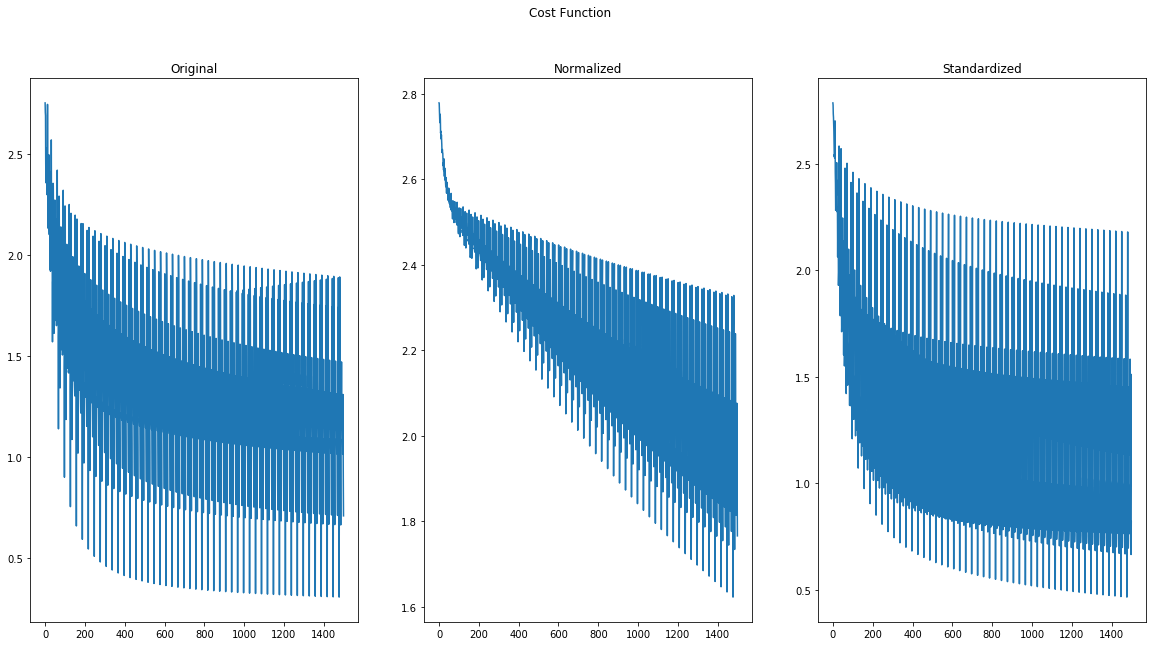

In [107]:
fig1, ax = plt.subplots(1,3,figsize=(20,10))

fig1.suptitle('Cost Function')

cost_o = np.zeros([3,1500])
cost_n = np.zeros([3,1500])
cost_s = np.zeros([3,1500])

for i in range(3):
    cost_o[i,:] = np.array(clf_o.clf[i].cost_)
    cost_n[i,:] = np.array(clf_n.clf[i].cost_)
    cost_s[i,:] = np.array(clf_s.clf[i].cost_)

ax[0].plot(np.mean(cost_o,axis=0))
ax[1].plot(np.mean(cost_n,axis=0))
ax[2].plot(np.mean(cost_s,axis=0))

ax[0].set_title('Original')
ax[1].set_title('Normalized')
ax[2].set_title('Standardized')

- 진동을 하지만 점차 조금씩 줄어드는 형태를 볼 수 있다.
- 초반부터 epoch이 확 줄어드는 것이 보인다.
- 실제로 epoch 수를 10 정도로 줄어도 일정 수준의 퍼포먼스를 보였다.

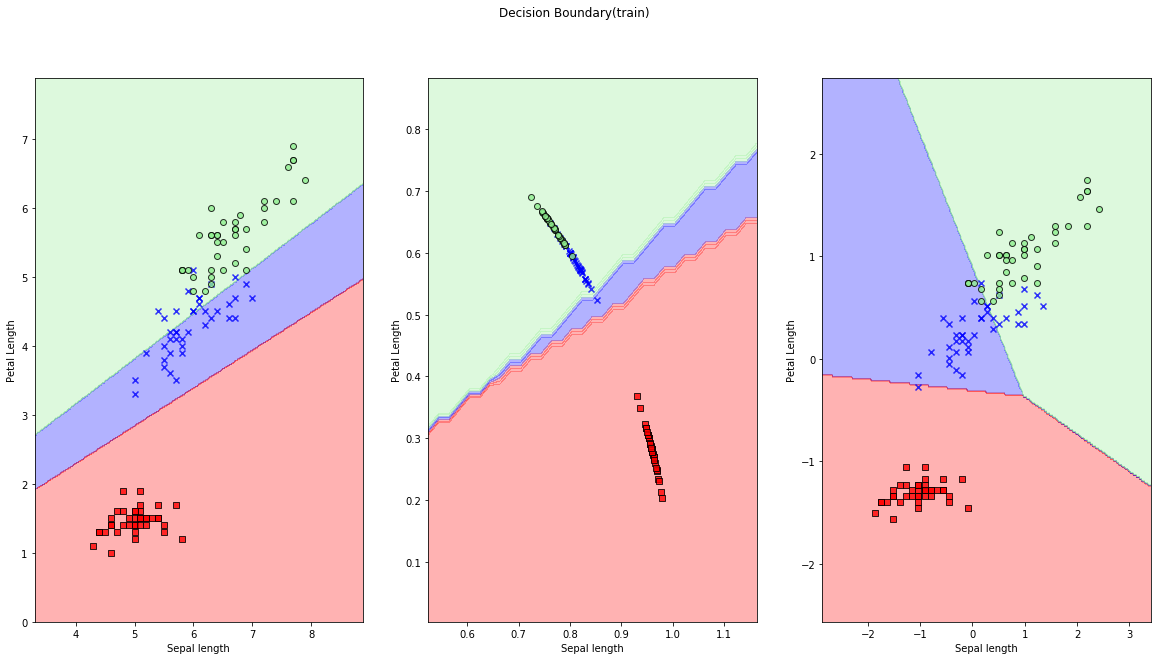

In [108]:
fig2, ax = plt.subplots(1,3,figsize=(20,10))

fig2.suptitle('Decision Boundary(train)')

plot_decision_regions(X_train,y_train,clf_o,ax= ax[0])
plot_decision_regions(X_train_norm,y_train,clf_n,ax= ax[1],graph_margin = 0.2)
plot_decision_regions(X_train_std,y_train,clf_s,ax= ax[2])

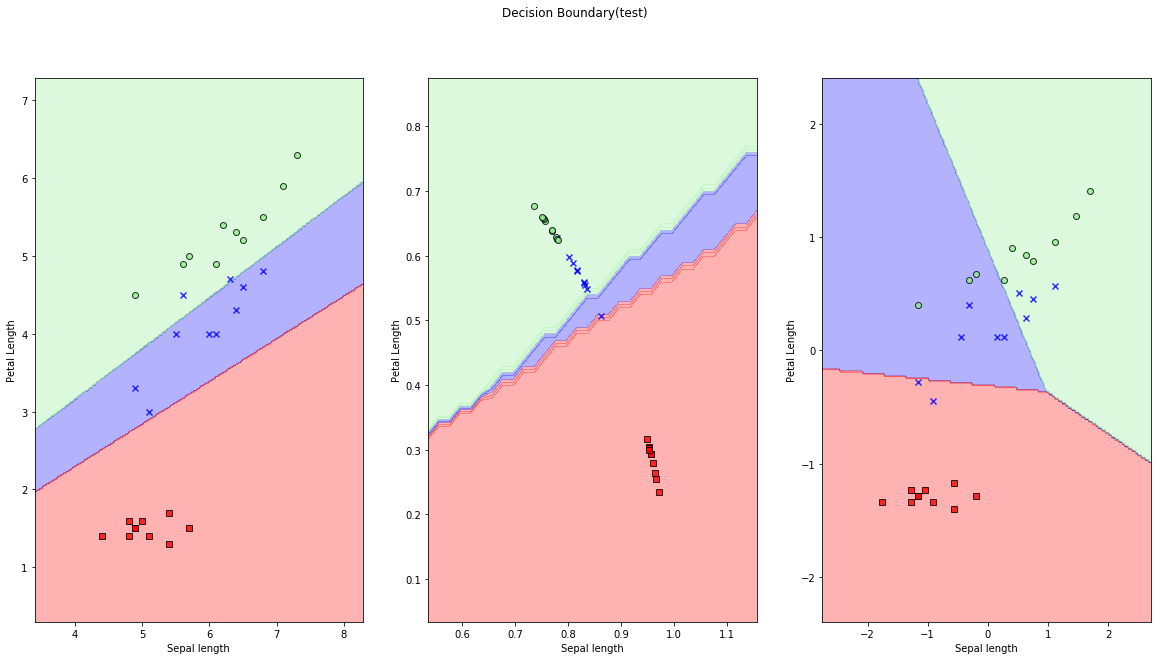

In [109]:
fig3, ax = plt.subplots(1,3,figsize=(20,10))

fig3.suptitle('Decision Boundary(test)')

plot_decision_regions(X_test,y_test,clf_o,ax= ax[0])
plot_decision_regions(X_test_norm,y_test,clf_n,ax= ax[1],graph_margin = 0.2)
plot_decision_regions(X_test_std,y_test,clf_s,ax= ax[2])

- normalize 한 데이터는 각 feature 들의 값이 -1과 1 사이에 존재해서 graph_margin을 바꾸어 주어야 했다.
- 전반적으로 standardized 한 데이터가 넓게 퍼져있어 fitting하기 좋았으나, 여기 parameter를 original에 맞게 설정하여 퍼포먼스가 떨어지는 것으로 보인다.


## 4. Implement the SVM algorithm
### 4-1. linear svm

In [110]:
svm_o = SVC(kernel='linear', C=1.0, random_state=1)
svm_o.fit(X_train, y_train)

svm_n = SVC(kernel='linear', C=1.0, random_state=1)
svm_n.fit(X_train_norm, y_train)

svm_s = SVC(kernel='linear', C=1.0, random_state=1)
svm_s.fit(X_train_std, y_train)

# 퍼포먼스 체크
print('Original Result(train) = %3f'%accuracy_score(y_train,svm_o.predict(X_train)))
print('Original Result(test) = %3f'%accuracy_score(y_test,svm_o.predict(X_test)))
print('Normalized Result(train) = %3f'%accuracy_score(y_train,svm_n.predict(X_train_norm)))
print('Normalized Result(test) = %3f'%accuracy_score(y_test,svm_n.predict(X_test_norm)))
print('Standardized Result(train) = %3f'%accuracy_score(y_train,svm_s.predict(X_train_std)))
print('Standardized Result(test) = %3f'%accuracy_score(y_test,svm_s.predict(X_test_std)))


Original Result(train) = 0.958333
Original Result(test) = 0.966667
Normalized Result(train) = 0.925000
Normalized Result(test) = 0.966667
Standardized Result(train) = 0.950000
Standardized Result(test) = 0.866667


#### 결과
>Original Result(train) = 0.966667

>Original Result(test) = 0.933333

>Normalized Result(train) = 0.900000

>Normalized Result(test) = 1.000000

>Standardized Result(train) = 0.950000

>Standardized Result(test) = 0.933333

- 모든 방법에서 매우 높은 정확도를 보여주었다.

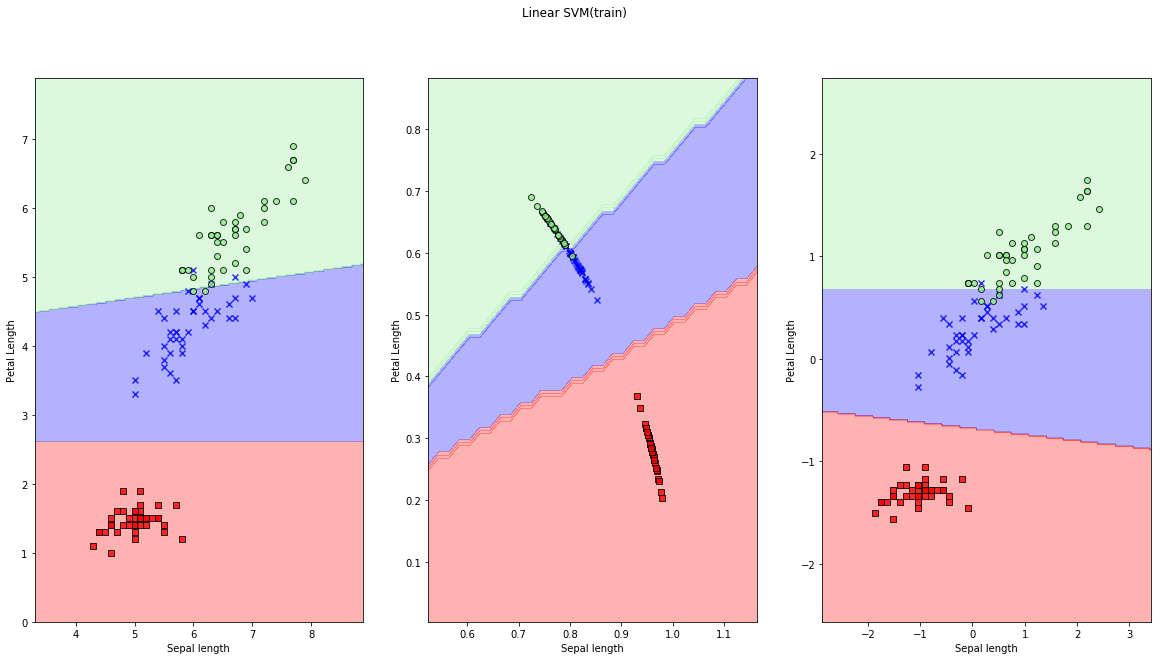

In [111]:
# Decision Boundary
fig4, ax = plt.subplots(1,3,figsize=(20,10))

fig4.suptitle('Linear SVM(train)')

plot_decision_regions(X_train,y_train,svm_o,ax= ax[0])
plot_decision_regions(X_train_norm,y_train,svm_n,ax= ax[1],graph_margin = 0.2)
plot_decision_regions(X_train_std,y_train,svm_s,ax= ax[2])

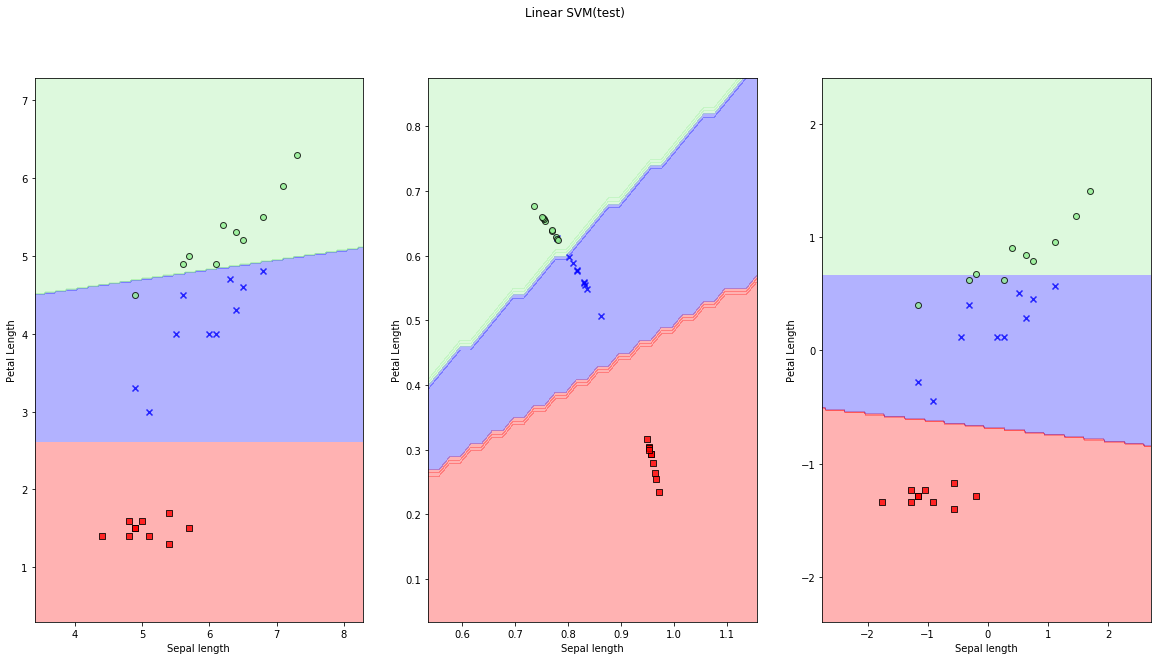

In [112]:
# Decision Boundary
fig5, ax = plt.subplots(1,3,figsize=(20,10))

fig5.suptitle('Linear SVM(test)')

plot_decision_regions(X_test,y_test,svm_o,ax= ax[0])
plot_decision_regions(X_test_norm,y_test,svm_n,ax= ax[1],graph_margin = 0.2)
plot_decision_regions(X_test_std,y_test,svm_s,ax= ax[2])

### 4-2. non-linear svm

In [113]:
svm_o = SVC(kernel='rbf', C=1.0, random_state=1)
svm_o.fit(X_train, y_train)

svm_n = SVC(kernel='rbf', C=1.0, random_state=1)
svm_n.fit(X_train_norm, y_train)

svm_s = SVC(kernel='rbf', C=1.0, random_state=1)
svm_s.fit(X_train_std, y_train)

# 퍼포먼스 체크
print('Original Result(train) = %3f'%accuracy_score(y_train,svm_o.predict(X_train)))
print('Original Result(test) = %3f'%accuracy_score(y_test,svm_o.predict(X_test)))
print('Normalized Result(train) = %3f'%accuracy_score(y_train,svm_n.predict(X_train_norm)))
print('Normalized Result(test) = %3f'%accuracy_score(y_test,svm_n.predict(X_test_norm)))
print('Standardized Result(train) = %3f'%accuracy_score(y_train,svm_s.predict(X_train_std)))
print('Standardized Result(test) = %3f'%accuracy_score(y_test,svm_s.predict(X_test_std)))


Original Result(train) = 0.950000
Original Result(test) = 0.966667
Normalized Result(train) = 0.925000
Normalized Result(test) = 0.966667
Standardized Result(train) = 0.950000
Standardized Result(test) = 0.866667


#### 결과
>Original Result(train) = 0.966667

>Original Result(test) = 0.900000

>Normalized Result(train) = 0.900000

>Normalized Result(test) = 1.000000

>Standardized Result(train) = 0.941667

>Standardized Result(test) = 0.800000

- 모든 방법에서 매우 높은 정확도를 보여주었다.

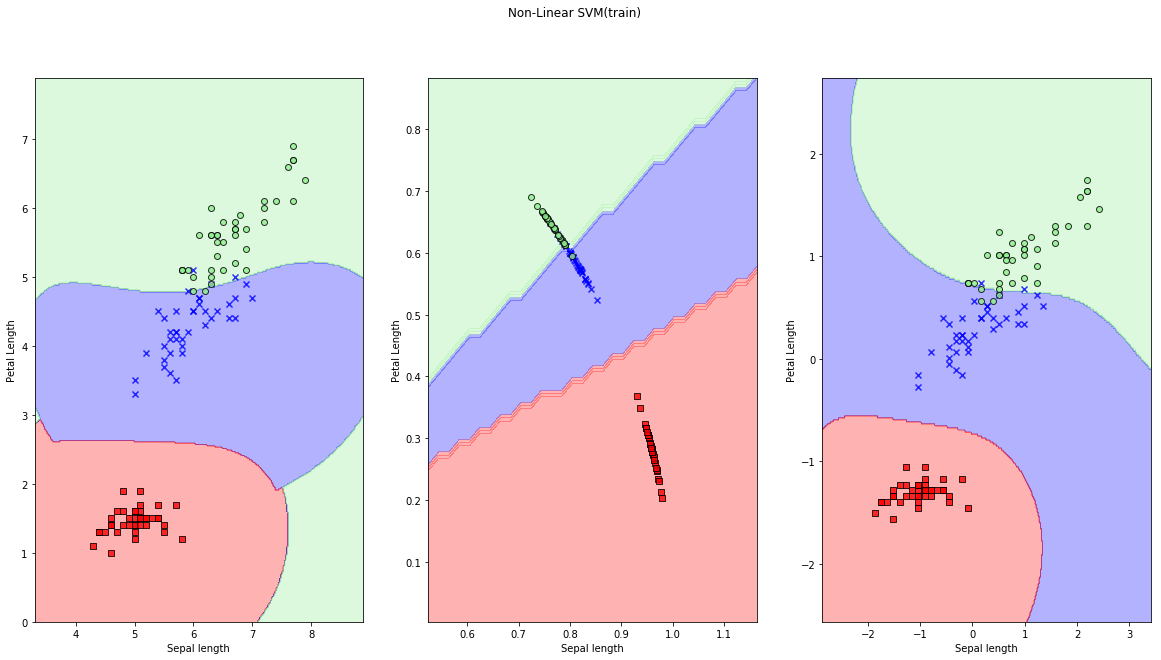

In [114]:
# Decision Boundary
fig6, ax = plt.subplots(1,3,figsize=(20,10))

fig6.suptitle('Non-Linear SVM(train)')

plot_decision_regions(X_train,y_train,svm_o,ax= ax[0])
plot_decision_regions(X_train_norm,y_train,svm_n,ax= ax[1],graph_margin = 0.2)
plot_decision_regions(X_train_std,y_train,svm_s,ax= ax[2])

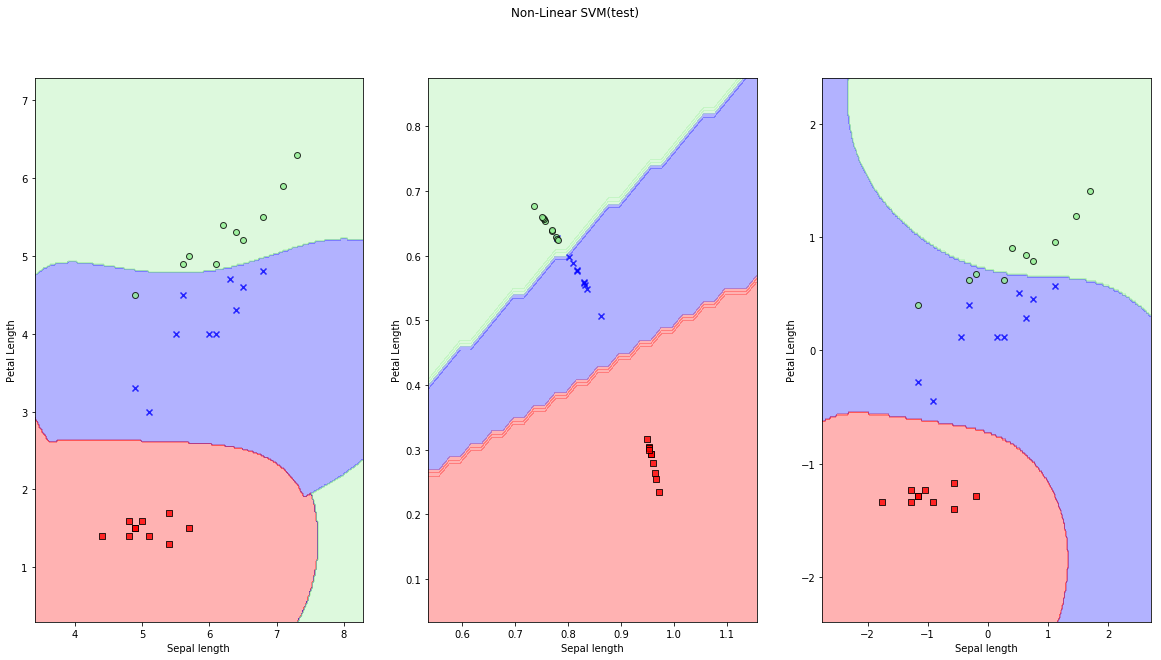

In [115]:
# Decision Boundary
fig7, ax = plt.subplots(1,3,figsize=(20,10))

fig7.suptitle('Non-Linear SVM(test)')

plot_decision_regions(X_test,y_test,svm_o,ax= ax[0])
plot_decision_regions(X_test_norm,y_test,svm_n,ax= ax[1],graph_margin = 0.2)
plot_decision_regions(X_test_std,y_test,svm_s,ax= ax[2])

- 전반적으로 linear SVM과는 다르게 decision boundary가 곡선으로 휘어있다.
- C 값을 사용해서 overfitting을 조절할 수 있는데 original 과 standardized 데이터의 경우는 C 값을 좀 더 줄여서 overfitting을 막아야 할 것으로 보인다.

## 5. Implement the random forest algorithm

In [116]:
forest_o = RandomForestClassifier(criterion='gini',n_estimators=25,random_state=1,n_jobs=2)
forest_o.fit(X_train,y_train)

forest_n = RandomForestClassifier(criterion='gini',n_estimators=25,random_state=1,n_jobs=2)
forest_n.fit(X_train_norm,y_train)

forest_s = RandomForestClassifier(criterion='gini',n_estimators=25,random_state=1,n_jobs=2)
forest_s.fit(X_train_std,y_train)

# 퍼포먼스 체크
print('Original Result(train) = %3f'%accuracy_score(y_train,forest_o.predict(X_train)))
print('Original Result(test) = %3f'%accuracy_score(y_test,forest_o.predict(X_test)))
print('Normalized Result(train) = %3f'%accuracy_score(y_train,forest_n.predict(X_train_norm)))
print('Normalized Result(test) = %3f'%accuracy_score(y_test,forest_n.predict(X_test_norm)))
print('Standardized Result(train) = %3f'%accuracy_score(y_train,forest_s.predict(X_train_std)))
print('Standardized Result(test) = %3f'%accuracy_score(y_test,forest_s.predict(X_test_std)))

Original Result(train) = 0.991667
Original Result(test) = 0.966667
Normalized Result(train) = 0.966667
Normalized Result(test) = 0.966667
Standardized Result(train) = 0.991667
Standardized Result(test) = 0.966667


#### 결과
>Original Result(train) = 0.991667

>Original Result(test) = 0.900000

>Normalized Result(train) = 0.983333

>Normalized Result(test) = 0.966667

>Standardized Result(train) = 0.991667

>Standardized Result(test) = 0.900000

- 이 역시 모든 방법에서 90% 이상의 매우 높은 정확도를 보여주었다.

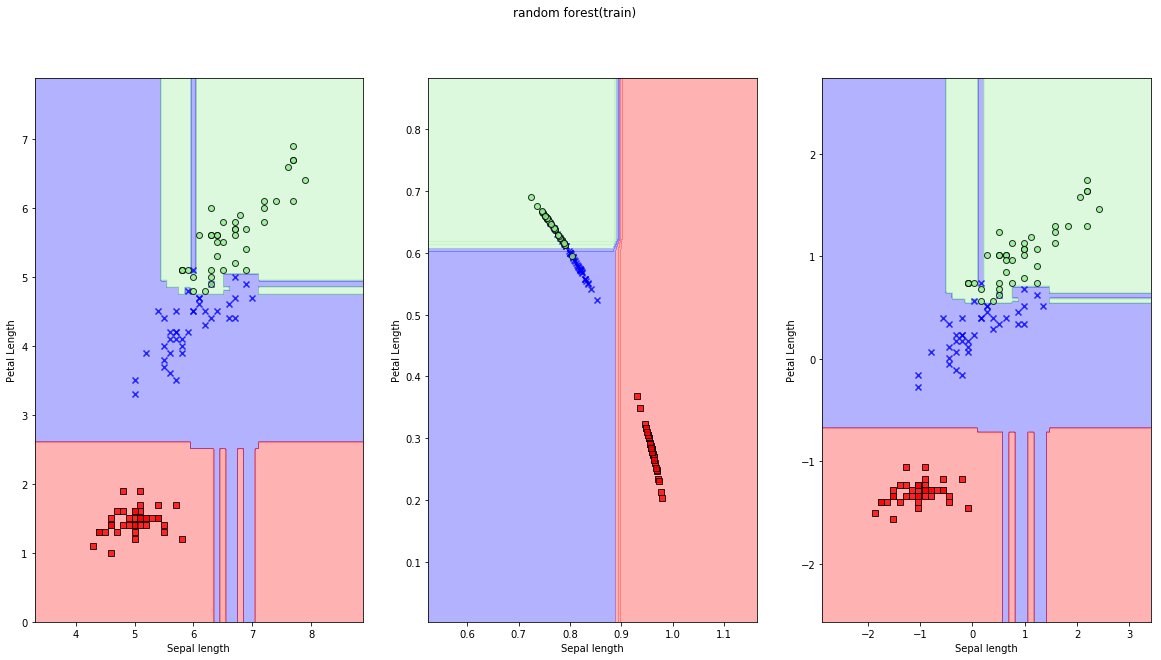

In [117]:
# Decision Boundary
fig8, ax = plt.subplots(1,3,figsize=(20,10))

fig8.suptitle('random forest(train)')

plot_decision_regions(X_train,y_train,forest_o,ax= ax[0])
plot_decision_regions(X_train_norm,y_train,forest_n,ax= ax[1],graph_margin = 0.2)
plot_decision_regions(X_train_std,y_train,forest_s,ax= ax[2])

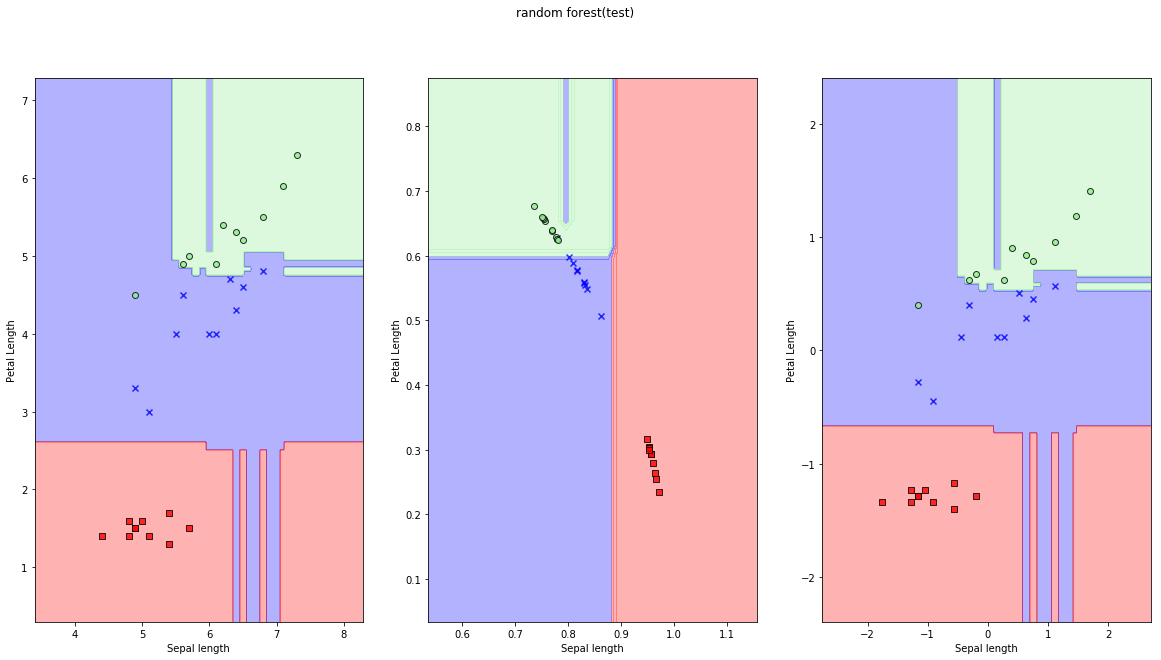

In [118]:
# Decision Boundary
fig9, ax = plt.subplots(1,3,figsize=(20,10))

fig9.suptitle('random forest(test)')

plot_decision_regions(X_test,y_test,forest_o,ax= ax[0])
plot_decision_regions(X_test_norm,y_test,forest_n,ax= ax[1],graph_margin = 0.2)
plot_decision_regions(X_test_std,y_test,forest_s,ax= ax[2])

- 다른 classifier와는 다르게 data의 경향성을 살리지 않고 일단 퍼포먼스가 좋은 tree를 살리는 방식이라 decision boundary가 조금 지저분함을 알 수 있다. 


## 6. Implement the k-nearest neighbore (KNN) algorithm
### 6-1. Euclidean Distance

In [119]:
knn_o = KNeighborsClassifier(n_neighbors=5,p=2,metric='minkowski')
knn_o.fit(X_train,y_train)

knn_n = KNeighborsClassifier(n_neighbors=5,p=2,metric='minkowski')
knn_n.fit(X_train_norm,y_train)

knn_s = KNeighborsClassifier(n_neighbors=5,p=2,metric='minkowski')
knn_s.fit(X_train_std,y_train)

# 퍼포먼스 체크
print('Original Result(train) = %3f'%accuracy_score(y_train,knn_o.predict(X_train)))
print('Original Result(test) = %3f'%accuracy_score(y_test,knn_o.predict(X_test)))
print('Normalized Result(train) = %3f'%accuracy_score(y_train,knn_n.predict(X_train_norm)))
print('Normalized Result(test) = %3f'%accuracy_score(y_test,knn_n.predict(X_test_norm)))
print('Standardized Result(train) = %3f'%accuracy_score(y_train,knn_s.predict(X_train_std)))
print('Standardized Result(test) = %3f'%accuracy_score(y_test,knn_s.predict(X_test_std)))

Original Result(train) = 0.958333
Original Result(test) = 0.966667
Normalized Result(train) = 0.941667
Normalized Result(test) = 0.966667
Standardized Result(train) = 0.950000
Standardized Result(test) = 0.966667


#### 결과
>Original Result(train) = 0.983333

>Original Result(test) = 0.900000

>Normalized Result(train) = 0.925000

>Normalized Result(test) = 0.966667

>Standardized Result(train) = 0.966667

>Standardized Result(test) = 0.866667

- 모든 방법에서 매우 높은 정확도를 보여주었다. 단, Standardized 의 경우 test set에 대해서 정확도가 조금 낮았다.

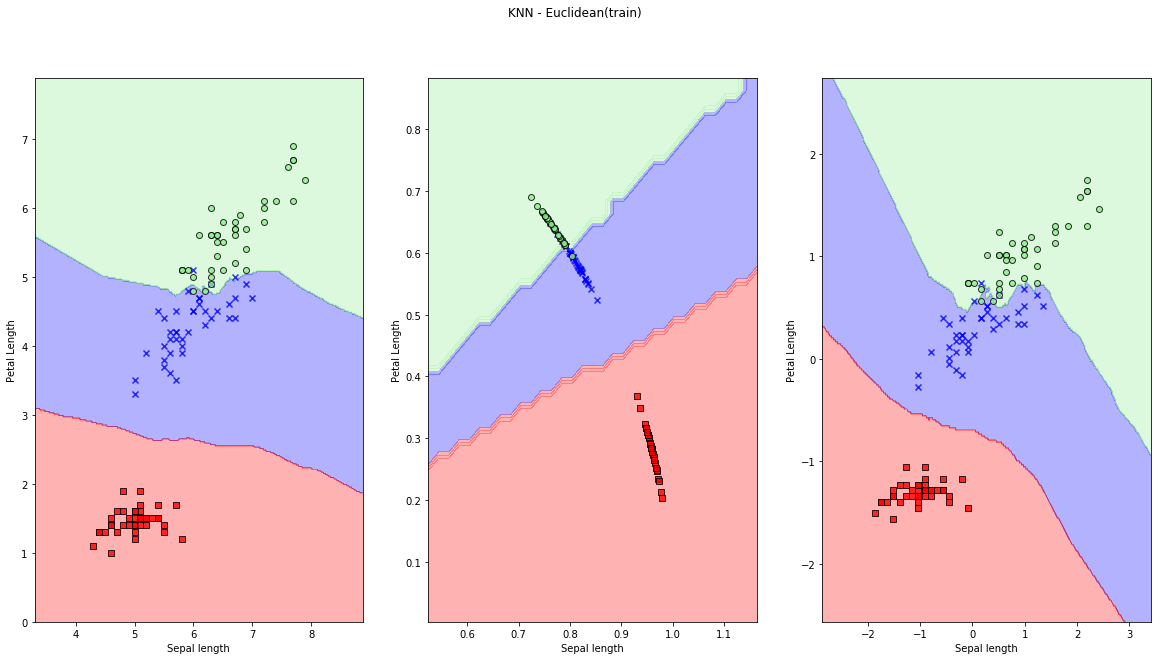

In [120]:
# Decision Boundary
fig10, ax = plt.subplots(1,3,figsize=(20,10))

fig10.suptitle('KNN - Euclidean(train)')

plot_decision_regions(X_train,y_train,knn_o,ax= ax[0])
plot_decision_regions(X_train_norm,y_train,knn_n,ax= ax[1],graph_margin = 0.2)
plot_decision_regions(X_train_std,y_train,knn_s,ax= ax[2])

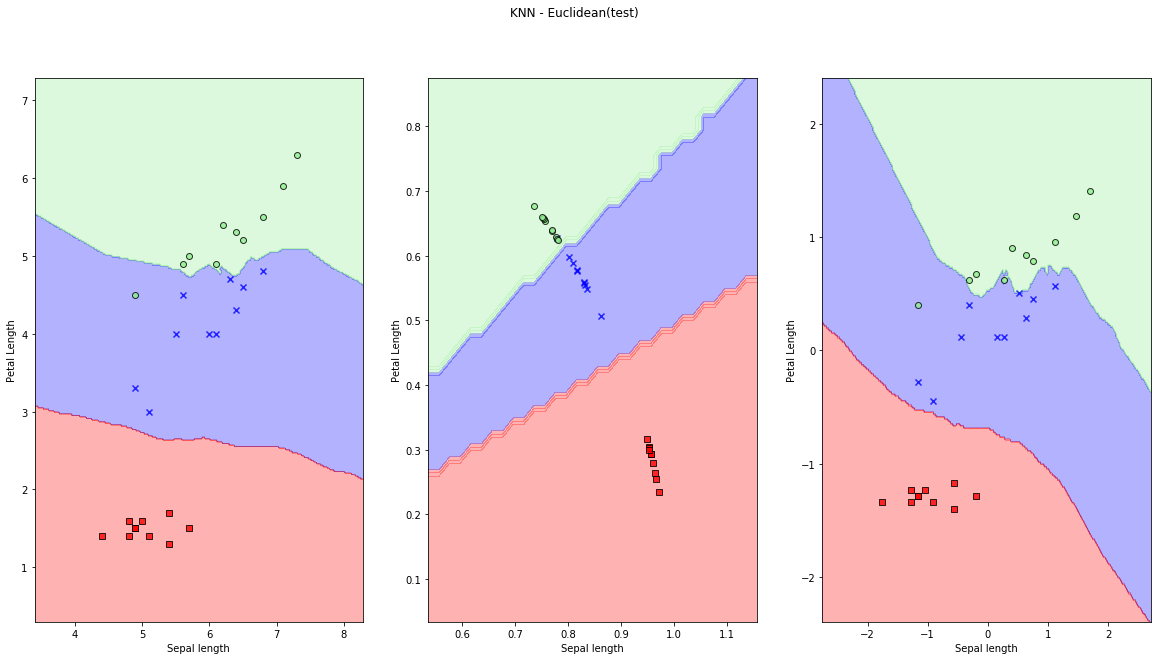

In [121]:
# Decision Boundary
fig11, ax = plt.subplots(1,3,figsize=(20,10))

fig11.suptitle('KNN - Euclidean(test)')

plot_decision_regions(X_test,y_test,knn_o,ax= ax[0])
plot_decision_regions(X_test_norm,y_test,knn_n,ax= ax[1],graph_margin = 0.2)
plot_decision_regions(X_test_std,y_test,knn_s,ax= ax[2])

- non-linear한 boundary가 관찰되었다.
- 전반적으로 이 역시 살짝 over fitting이 되는 경향성이 나타났다.

### 6-2. Manhattan Distance

In [122]:
knn_o = KNeighborsClassifier(n_neighbors=5,p=1,metric='minkowski')
knn_o.fit(X_train,y_train)

knn_n = KNeighborsClassifier(n_neighbors=5,p=1,metric='minkowski')
knn_n.fit(X_train_norm,y_train)

knn_s = KNeighborsClassifier(n_neighbors=5,p=1,metric='minkowski')
knn_s.fit(X_train_std,y_train)

# 퍼포먼스 체크
print('Original Result(train) = %3f'%accuracy_score(y_train,knn_o.predict(X_train)))
print('Original Result(test) = %3f'%accuracy_score(y_test,knn_o.predict(X_test)))
print('Normalized Result(train) = %3f'%accuracy_score(y_train,knn_n.predict(X_train_norm)))
print('Normalized Result(test) = %3f'%accuracy_score(y_test,knn_n.predict(X_test_norm)))
print('Standardized Result(train) = %3f'%accuracy_score(y_train,knn_s.predict(X_train_std)))
print('Standardized Result(test) = %3f'%accuracy_score(y_test,knn_s.predict(X_test_std)))

Original Result(train) = 0.975000
Original Result(test) = 0.966667
Normalized Result(train) = 0.941667
Normalized Result(test) = 0.966667
Standardized Result(train) = 0.950000
Standardized Result(test) = 0.900000


#### 결과
>Original Result(train) = 0.983333

>Original Result(test) = 0.900000

>Normalized Result(train) = 0.925000

>Normalized Result(test) = 0.966667

>Standardized Result(train) = 0.950000

>Standardized Result(test) = 0.900000

- 모든 방법에서 매우 높은 정확도를 보여주었다.

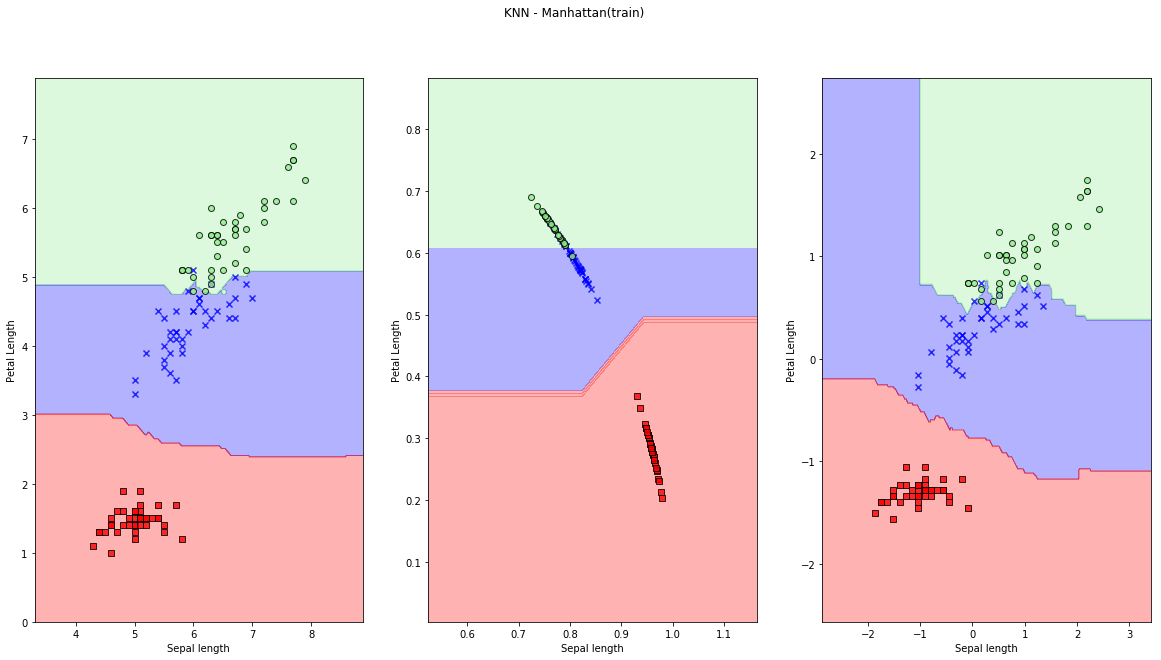

In [123]:
# Decision Boundary
fig12, ax = plt.subplots(1,3,figsize=(20,10))

fig12.suptitle('KNN - Manhattan(train)')

plot_decision_regions(X_train,y_train,knn_o,ax= ax[0])
plot_decision_regions(X_train_norm,y_train,knn_n,ax= ax[1],graph_margin = 0.2)
plot_decision_regions(X_train_std,y_train,knn_s,ax= ax[2])

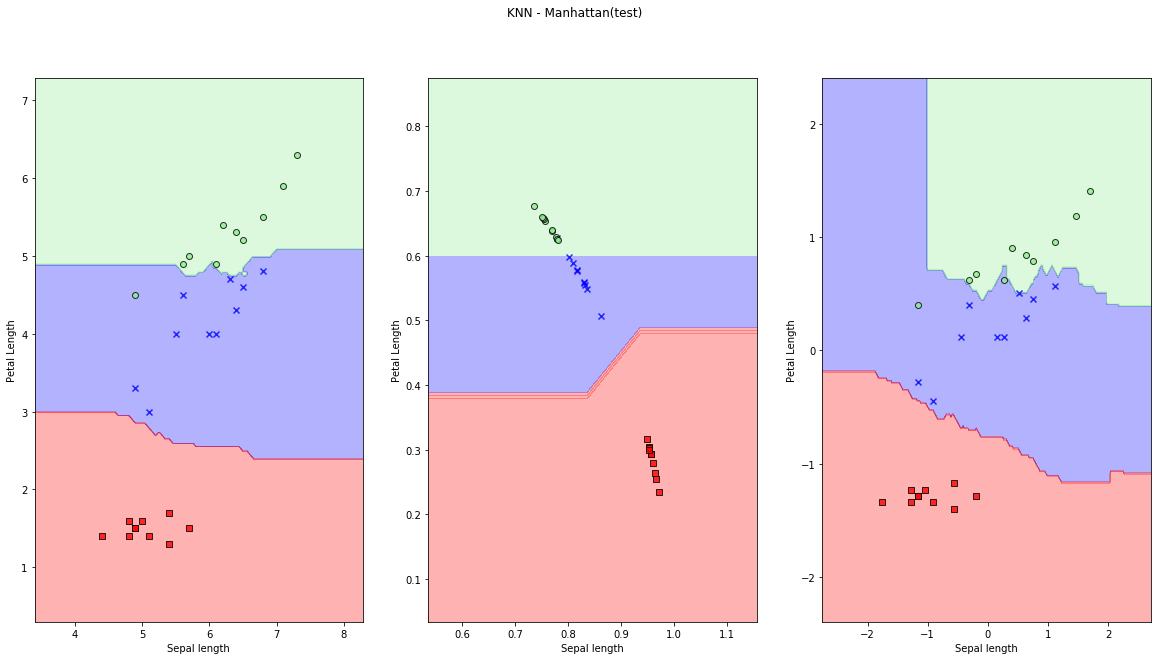

In [124]:
# Decision Boundary
fig13, ax = plt.subplots(1,3,figsize=(20,10))

fig13.suptitle('KNN - Manhattan(test)')

plot_decision_regions(X_test,y_test,knn_o,ax= ax[0])
plot_decision_regions(X_test_norm,y_test,knn_n,ax= ax[1],graph_margin = 0.2)
plot_decision_regions(X_test_std,y_test,knn_s,ax= ax[2])

- non-linear한 boundary가 관찰되었다.
- 전반적으로 이 역시 살짝 over fitting이 되는 경향성이 나타났다.

## 결론
- 모든 classifier가 일정수준(약 90% 이상)의 퍼포먼스를 보였다.
- 하지만 각각의 classifier가 그리는 deicision boundary의 모양은 상이했다.
- Normalized 하는 경우 극좌표계에 plotting하는 듯한 효과가 나타났고, 이는 전반적으로 feature의 특징을 살리지 못해 부정적인 결과를 낳았다.
- Standardize 하는 경우 좀 더 중앙점을 중심으로 데이터를 일정하게 퍼뜨려 선형적으로 구분이 쉽게 되었다.
- 데이터 별로 특징이 다르겠지만 적어도 이 iris dataset에서는 개인적인 생각으론 KNN - Euclidean 방식이 overfitting 문제도 적고 데이터의 경향성을 잘 살리는 분류방식인것 같다.